In [97]:
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2 as cv
import scipy as sp
import pandas as pd
import csv

Laplace equation:  

- solve the Laplace equation using CUDA. (10 points)

- draw the heatmap of the solution u(x,y) using anything you want (10 points)

Here are the equation and the boundary conditions.

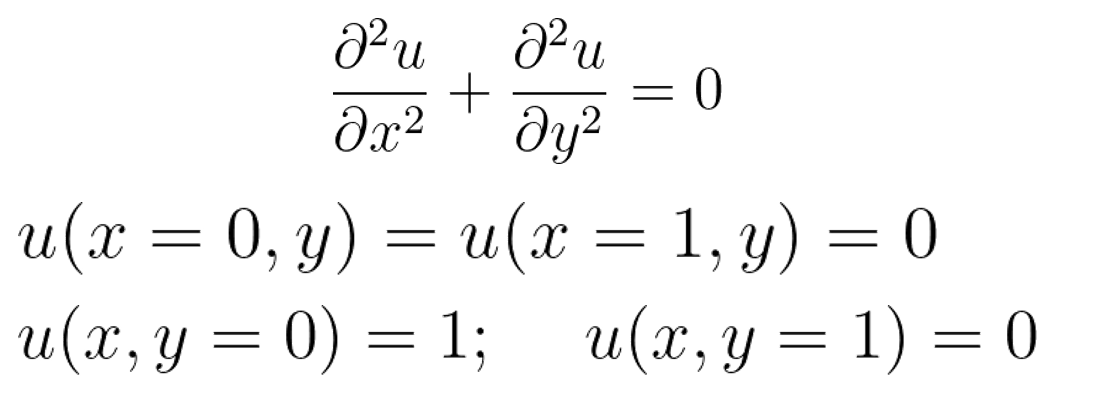  

A good explanation of how to discretize the Laplace equation is given here (Links to an external site.) (starting from page 3). In principle you can use any of the 3 approaches:

- discretize the equation and get (NM)^2 sparse linear system and inverse the matrix;

- discretize the equation and get (NM)^2 sparse linear system and solve it iteratively;

- try to achieve the steady-state solution of the corresponding heat equation with some initial conditions (replace 0 with du/dt and kind of do what we did in seminar 4 until the solution more or less stops changing in time).

In [1]:
%%writefile Laplace.cu
#include <stdio.h>

const int N = 50;
#define max_iter 500

__global__ void Init(float * dA)
{
    int idx = threadIdx.x + blockIdx.x * blockDim.x;

    if(idx < N*N)
    { 
        if (blockIdx.x != 0) dA[idx] = 0;
        else 
        {
            if ((threadIdx.x == 0) | (threadIdx.x == N-1)) dA[idx] = 0;
            else dA[idx] = 1;
        }
    }  
}

__global__ void Step(float *T_old, float *T_new)
{
    int idx = threadIdx.x + blockIdx.x * blockDim.x;
    int up, down, right, left;

    if(idx < N*N)
    { 
        if((blockIdx.x != 0) && (blockIdx.x !=  N-1))
        {
            if((threadIdx.x != 0) && (threadIdx.x !=  N-1))
            {
                right = (blockIdx.x + 1) * blockDim.x + threadIdx.x;
                left = (blockIdx.x - 1) * blockDim.x + threadIdx.x;            
                up = blockIdx.x * blockDim.x + threadIdx.x + 1;
                down = blockIdx.x * blockDim.x + threadIdx.x - 1;
             
                T_new[idx] = 0.25* (T_old[up] + T_old[down] + T_old[right] + T_old[left]);
            }
        }
    }  
}
int main()
{
    float *T_old;
    float *T;

    cudaMallocManaged(&T_old, sizeof(float)*N*N);
    cudaMallocManaged(&T, sizeof(float)*N*N);

    Init<<<N,N>>>(T_old);
    Init<<<N,N>>>(T);
 
    int k = 0;
    while(k< max_iter){
        Step<<<N,N>>>(T_old, T);
        Step<<<N,N>>>(T, T_old);
        k++;
    }

    cudaDeviceSynchronize();

    FILE *fp=NULL;
    fp = fopen("heatmap.txt","w");

    for (int j=0; j < N; j++)
    {
        for (int i=0; i < N; i++)
        {
            fprintf(fp, "%f ", T[i + j * N]);
        }
        fprintf(fp, "\n");
    }

    cudaDeviceSynchronize();
 
    fclose(fp);
    cudaFree(T_old);
    cudaFree(T);

    return 0;
}

Writing Laplace.cu


In [30]:
!nvcc Laplace.cu -o laplace

In [31]:
!./laplace

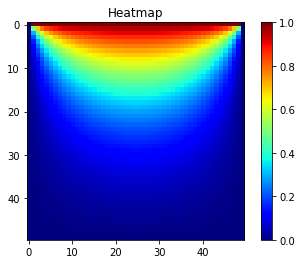

In [32]:
heatmap = np.loadtxt('heatmap.txt')
plt.imshow(heatmap, cmap=plt.cm.jet)
plt.colorbar()
plt.title('Heatmap')
plt.show()

 Filtering:

Take an arbitrary image and apply two types of filters to it using CUDA.

- Blurring filter (have at least 2 blurring filters - they can differ in stencil size or the values of the filter matrix for example) (15 points)

- Median filter (try to achieve the cartoonish effect) (15 points)

In [2]:
%%writefile blur_filter.cu

#include "lodepng.h"
#define STB_IMAGE_IMPLEMENTATION
#define STB_IMAGE_WRITE_IMPLEMENTATION
#include "stb_image.h"
#include "stb_image_write.h"
#include <iostream>

#define BLUR_SIZE 7
#define R 0
#define G 1
#define B 2
#define A 3

__global__ void blur(unsigned char* in, unsigned char* out, int width, int height, int num_channel, int channel, int copy_A) {

  int col = blockIdx.x * blockDim.x + threadIdx.x;
  int row = blockIdx.y * blockDim.y + threadIdx.y;

  if(col < width && row < height) {
    int pixVal = 0;
    int pixels = 0;
    if (copy_A)
      out[row*width*num_channel+col*num_channel+A] = in[row*width*num_channel+col*num_channel+A];
    for(int blurRow = -BLUR_SIZE; blurRow < BLUR_SIZE + 1; ++blurRow) {
      for(int blurCol = -BLUR_SIZE; blurCol < BLUR_SIZE + 1; ++blurCol) {
        int curRow = row + blurRow;
        int curCol = col + blurCol;
        if(curRow > -1 && curRow < height && curCol > -1 && curCol < width) {
          pixVal += in[curRow * width * num_channel + curCol * num_channel + channel];
          pixels++;
        }
      }
    }
    out[row * width * num_channel + col * num_channel + channel] = (unsigned char)(pixVal/pixels);
  }
}

int main() {

  int width, height,n;
  unsigned char *image = stbi_load("image.png",&width,&height,&n,0);

  unsigned char* Input_Image = NULL;
  unsigned char* Output_Image = NULL;
  cudaMalloc((void**)&Input_Image, sizeof(unsigned char)* height * width * n);
  cudaMalloc((void**)&Output_Image, sizeof(unsigned char)* height * width * n);

  cudaMemcpy(Input_Image, image, sizeof(unsigned char) * height * width * n, cudaMemcpyHostToDevice);

  int BlocksPerThread = 16;
  dim3 blockSize(BlocksPerThread, BlocksPerThread, 1);
  dim3 gridSize(width/blockSize.x, height/blockSize.y,1);

  //blurring
  blur <<<gridSize, blockSize>>>(Input_Image, Output_Image, width, height,n,R,0);
  blur <<<gridSize, blockSize>>>(Input_Image, Output_Image, width, height,n,G,0);
  blur <<<gridSize, blockSize>>>(Input_Image, Output_Image, width, height,n,B,1);
  
  cudaDeviceSynchronize();

  cudaMemcpy(image, Output_Image, sizeof(unsigned char) * height * width * n, cudaMemcpyDeviceToHost);
  cudaFree(Input_Image);
  cudaFree(Output_Image);
  stbi_write_png("blurred.png", width, height, n, image, width * n);

  return 0;
}

Writing blur_filter.cu


In [ ]:
!nvcc blur_filter.cu -o blur_filter

In [94]:
!./blur_filter

In [95]:
img = Image.open('image.png')
blurred = Image.open('blurred.png') 

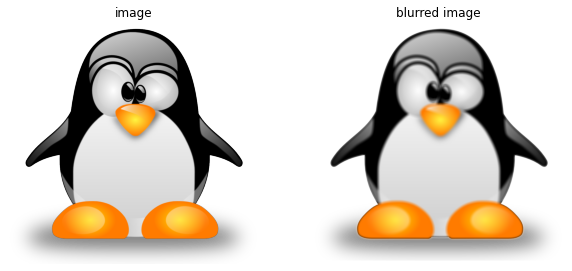

In [96]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 12))
axs[0].set_title('image')
axs[0].imshow(img)
axs[0].axis('off')

axs[1].set_title('blurred image')
axs[1].imshow(blurred)
axs[1].axis('off')
plt.show()

In [3]:
%%writefile median_filter.cu

#include "lodepng.h"
#define STB_IMAGE_IMPLEMENTATION
#define STB_IMAGE_WRITE_IMPLEMENTATION
#include "stb_image.h"
#include "stb_image_write.h"
#include <iostream>

#define WINDOW_SIZE 3
#define MEDIAN_DIMENSION 3    
#define MEDIAN_LENGTH 9   
#define BLOCK_WIDTH 16  
#define BLOCK_HEIGHT 16

#define R 0
#define G 1
#define B 2
#define A 3

__global__ void median( unsigned char *image, int width,int height, int num_channel, int channel, int copy_A){

    unsigned char out[BLOCK_WIDTH*BLOCK_HEIGHT][MEDIAN_LENGTH];

    int iterator;
    int Half_Of_MEDIAN_LENGTH =(MEDIAN_LENGTH/2)+1;
    int start=MEDIAN_DIMENSION/2;
    int end=start+1;

    int x = blockDim.x * blockIdx.x + threadIdx.x;
    int y = blockDim.y * blockIdx.y + threadIdx.y;
    int tid = threadIdx.y*blockDim.y+threadIdx.x;   

      if(x>=width || y>=height)
        return;
        if (copy_A)
        *(image+(y*width * num_channel)+x * num_channel + A) = image[y*width*num_channel+x*num_channel+A];
            if (x == 0 || x == width - start || y == 0
                || y == height - start) {
            } else {             
                iterator = 0;
                for (int r = x - start; r < x + (end); r++) {
                    for (int c = y - start; c < y + (end); c++) {
                        out[tid][iterator] =*(image+(c*width*num_channel)+r * num_channel + channel);
                        iterator++;
                    }
                }
                      int t,j,i;
                    for ( i = 1 ; i< MEDIAN_LENGTH ; i++) {
                        j = i;
                        while ( j > 0 && out[tid][j] < out[tid][j-1]) {
                            t= out[tid][j];
                            out[tid][j]= out[tid][j-1];
                            out[tid][j-1] = t;
                            j--;
                        }
                    }

                    *(image+(y*width * num_channel)+x * num_channel + channel)= out[tid][Half_Of_MEDIAN_LENGTH-1];
            }  
}

int main() {

  int width, height,n;
  unsigned char *image = stbi_load("image.png",&width,&height,&n,0);

  unsigned char* Input_Image = NULL;
  unsigned char* Output_Image = NULL;
  cudaMalloc((void**)&Input_Image, sizeof(unsigned char)* height * width * n);
  cudaMalloc((void**)&Output_Image, sizeof(unsigned char)* height * width * n);

  cudaMemcpy(Input_Image, image, sizeof(unsigned char) * height * width * n, cudaMemcpyHostToDevice);

  int BlocksPerThread = 16;
  dim3 blockSize(BlocksPerThread, BlocksPerThread, 1);
  dim3 gridSize(width/blockSize.x, height/blockSize.y,1);

  //median filtering
  median <<<gridSize, blockSize>>>(Input_Image, width, height,n,R,0);
  median <<<gridSize, blockSize>>>(Input_Image, width, height,n,G,0);
  median <<<gridSize, blockSize>>>(Input_Image, width, height,n,B,1);
  
  cudaDeviceSynchronize();

  cudaMemcpy(image, Input_Image, sizeof(unsigned char) * height * width * n, cudaMemcpyDeviceToHost);
  cudaFree(Input_Image);
  cudaFree(Output_Image);
  stbi_write_png("median.png", width, height, n, image, width * n);

  return 0;
}

Writing median_filter.cu


In [197]:
!nvcc median_filter.cu -o median_filter

stb_image.h(4207): warning: variable "old_limit" was set but never used

stb_image.h(5121): warning: variable "idata_limit_old" was set but never used

stb_image.h(6894): warning: variable "out_size" was set but never used

stb_image.h(6895): warning: variable "delays_size" was set but never used



In [198]:
!./median_filter

In [199]:
img = Image.open('image.png')
median = Image.open('median.png') 

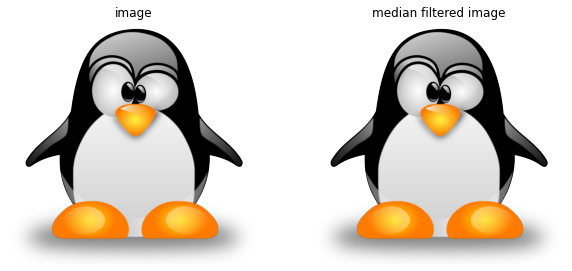

In [200]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 12))
axs[0].set_title('image')
axs[0].imshow(img)
axs[0].axis('off')

axs[1].set_title('median filtered image')
axs[1].imshow(median)
axs[1].axis('off')
plt.show()

Histogram:

You need to plot a  histogram for a chosen picture. For this purpose:

- take any picture -> grayscale it -> calculate the histogram for the picture using CUDA (10 points)

- plot the resulting histogram using anything you want (10 points)

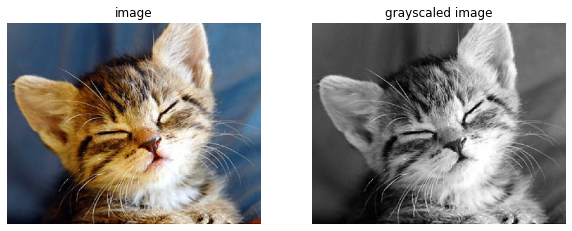

In [271]:
img = Image.open("cat.jpg")
img_gray = ImageOps.grayscale(img)
img_gray.save('gray_cat.jpg')

fig, axs = plt.subplots(ncols=2, figsize=(10, 12))
axs[0].set_title('image')
axs[0].imshow(img)
axs[0].axis('off')

axs[1].set_title('grayscaled image')
axs[1].imshow(img_gray, cmap='gray', vmin=0, vmax=255)
axs[1].axis('off')
plt.show()

In [272]:
image  = imread("gray_cat.jpg") 
with open('greysacaleimage.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=" ")
    [writer.writerow(r) for r in image]

In [273]:
height ,width = image.shape

In [274]:
image.shape

(350, 441)

In [5]:
%%writefile histogram.cu

#include <stdio.h>
#include <string.h>
#include <math.h>
#include <stdint.h>

#define STB_IMAGE_IMPLEMENTATION
#define STB_IMAGE_WRITE_IMPLEMENTATION

#include "stb_image.h"
#include "stb_image_write.h"

__global__ void Hist(int height, int width,  uint8_t *d_image, unsigned int *d_res)
{
        int globalidx = threadIdx.x + blockDim.x * blockIdx.x;
	long int size = height * width;	
	// uint8_t tid = threadIdx.x;

	if (globalidx < size)
	{

		unsigned char value = d_image[globalidx];
		int bin = value % 256;
		atomicAdd(&d_res[bin], 1);
		//__syncthreads();				
	}
}

int main(int argc, char **argv)
{
	int width, height, bpp, size;
	FILE *fp;
	fp = fopen("hist.txt", "w");

	uint8_t* h_image_init = stbi_load("grey_cat.jpg", &width, &height, &bpp, 3);		
	size = height * width;

	uint8_t* h_image = (uint8_t *) malloc(sizeof(uint8_t) * size);
	for (int i = 0; i < width; i++)
	{
		for (int j = 0; j < height; j++)
		{
			h_image[j*width + i] = (h_image_init[j*width*3 + i*3] + \
						h_image_init[j*width*3 + i*3 + 1] + \
						h_image_init[j*width*3 + i*3 + 2]) / 3.;		
		}
	}

	uint8_t *d_image;
	unsigned int *d_res;
	unsigned int *h_res = (unsigned int *) malloc(sizeof(unsigned int) * 256);
	cudaMalloc(&d_image, sizeof(uint8_t) * size);
	cudaMalloc(&d_res, sizeof(unsigned int) * 256);
	cudaMemset(d_res, 0, sizeof(unsigned int) * 256);
	
	cudaMemcpy(d_image, h_image, sizeof(uint8_t) * size, cudaMemcpyHostToDevice);
  int block_size, grid_size;
	block_size = 256;
  grid_size = size / 256;

  dim3 dimBlock(block_size);
  dim3 dimGrid(grid_size);

	Hist<<<dimGrid, dimBlock>>>(height, width, d_image, d_res);
	cudaDeviceSynchronize();	

	cudaMemcpy(h_res, d_res, sizeof(unsigned int) * 256, cudaMemcpyDeviceToHost);
	
	for (int i = 0; i < 256; i++)
	{
		fprintf(fp, "%d\t", h_res[i]);
	}
	fprintf(fp, "\n");

	free(h_image);
	free(h_res);
	cudaFree(d_image);
	cudaFree(d_res);
	fclose(fp);

	return 0;	
}

Overwriting histogram.cu


In [294]:
!nvcc histogram.cu -o histogram

stb_image.h(4207): warning: variable "old_limit" was set but never used

stb_image.h(5121): warning: variable "idata_limit_old" was set but never used

stb_image.h(6894): warning: variable "out_size" was set but never used

stb_image.h(6895): warning: variable "delays_size" was set but never used



In [295]:
!./histogram

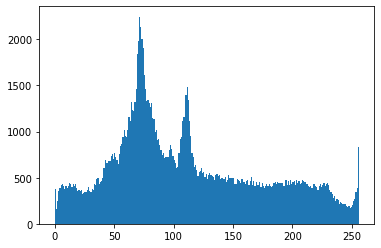

In [208]:
hist = np.loadtxt('hist.txt')
plt.hist(hist,256,[0,256])
plt.show()